In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler, TensorDataset
import numpy as np
import io
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets.utils import download_url
import random
import optuna_integration
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
writer = SummaryWriter('runs/conv_vae_experiment')

In [4]:
# Downloading the Moving MNIST dataset
url = "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy"
fpath = "moving_mnist.npy"
download_url(url, root=".", filename=fpath)
dataset = np.load(fpath)

# Swapping the axes representing the number of frames and number of data samples
dataset = np.swapaxes(dataset, 0, 1)

# We pick out 1000 of the 10000 total examples and use those
dataset = dataset[:8000, ...]

# Adding a channel dimension since the images are grayscale
dataset = np.expand_dims(dataset, axis=-1)

# Splitting into train and validation sets using indexing to optimize memory
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

'''
# Normalizing the data to the 0-1 range
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

'''

#normalizing the data to have zero mean and unit variance
mean = train_dataset.mean()
std = train_dataset.std()
train_dataset = (train_dataset - mean) / std
val_dataset = (val_dataset - mean) / std


# We define a helper function to shift the frames, where
# 'x' is frame 0 to n - 1, and 'y' is frames 1 to n
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Convert numpy arrays to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=20)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=20)

# Inspect the dataset
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Using downloaded and verified file: ./moving_mnist.npy
Training Dataset Shapes: torch.Size([7200, 19, 64, 64, 1]), torch.Size([7200, 19, 64, 64, 1])
Validation Dataset Shapes: torch.Size([800, 19, 64, 64, 1]), torch.Size([800, 19, 64, 64, 1])


Displaying frames for example 730.


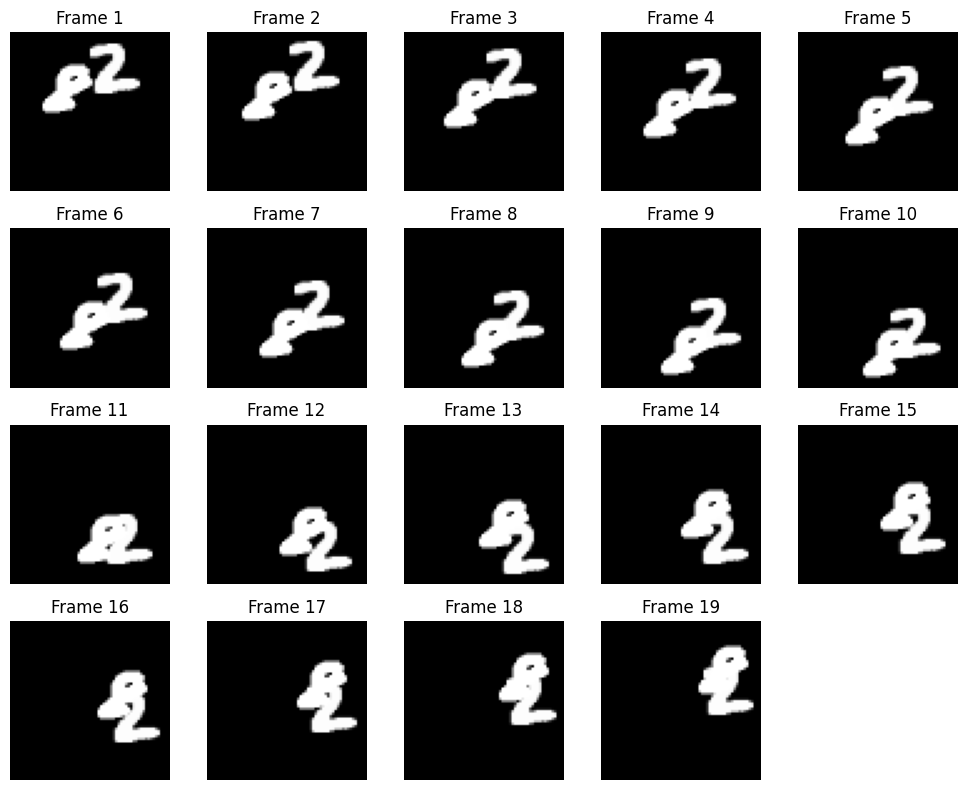

In [5]:
# Construct a figure on which we will visualize the images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
frames = train_dataset.tensors[0][data_choice]

for idx, ax in enumerate(axes.flat):
    if idx < frames.shape[0]:
        frame = frames[idx].squeeze().numpy()
        ax.imshow(frame, cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.axis("off")
    else:
        ax.axis("off")

# Print information and display the figure
print(f"Displaying frames for example {data_choice}.")
plt.tight_layout()
plt.show()

In [6]:
# Define the Sampling module
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch = z_mean.size(0)
        dim = z_mean.size(1)
        epsilon = torch.randn(batch, dim, device=z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

# Define the Encoder module
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv3d(input_shape[3], 128, kernel_size=(3, 5, 5), padding=(1, 2, 2), stride=(1, 2, 2))
        self.bn1 = nn.BatchNorm3d(128)
        self.conv2 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(256)
        self.conv3 = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2))
        self.bn3 = nn.BatchNorm3d(512)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(512 * input_shape[0] * input_shape[1] // 8 * input_shape[2] // 8, latent_dim * 2)

    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)  # Rearrange dimensions to (batch_size, channels, frames, height, width)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        x = self.dense1(x)
        z_mean, z_log_var = torch.chunk(x, 2, dim=1)
        return z_mean, z_log_var

# Define the Decoder module
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(latent_dim, 512 * output_shape[0] * output_shape[1] // 8 * output_shape[2] // 8)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512, output_shape[0], output_shape[1] // 8, output_shape[2] // 8))
        self.deconv1 = nn.ConvTranspose3d(512, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2), output_padding=(0, 1, 1))
        self.bn1 = nn.BatchNorm3d(256)
        self.deconv2 = nn.ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2), output_padding=(0, 1, 1))
        self.bn2 = nn.BatchNorm3d(128)
        self.deconv3 = nn.ConvTranspose3d(128, output_shape[3], kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2), output_padding=(0, 1, 1))

    def forward(self, z):
        z = self.dense1(z)
        z = self.unflatten(z)
        z = torch.relu(self.bn1(self.deconv1(z)))
        z = torch.relu(self.bn2(self.deconv2(z)))
        recon_x = torch.sigmoid(self.deconv3(z))
        recon_x = recon_x.permute(0, 2, 3, 4, 1)  # Rearrange dimensions back to (batch_size, frames, height, width, channels)
        return recon_x

# Define the VAE module
class VAE(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_shape, latent_dim)
        self.decoder = Decoder(latent_dim, input_shape)

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = Sampling()(z_mean, z_log_var)
        recon_x = self.decoder(z)
        return z_mean, z_log_var, recon_x

In [7]:
# Define the loss function
def vae_loss(x, recon_x, z_mean, z_log_var):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var))
    return recon_loss + kl_div

from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
import tqdm
import torch

# Define the loss function
def vae_loss(x, recon_x, z_mean, z_log_var):
    recon_loss = nn.functional.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var))
    return recon_loss + kl_div

# Function to visualize reconstructions
def visualize_reconstructions(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        for examples in val_loader:
            examples = examples[0].to(device)
            z_mean, z_log_var, recon_examples = model(examples)
            break

    examples = examples.cpu().numpy()
    recon_examples = recon_examples.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(examples[i, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_examples[i, 0], cmap='gray')
        axes[1, i].axis('off')
    plt.show()
    
# Function to train the VAE model for hyperparameter search
def train_for_search(model, train_loader, val_loader, optimizer, scheduler, epochs, device):
    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            # Forward pass and loss computation
            z_mean, z_log_var, recon_x = model(batch)
            loss = vae_loss(batch, recon_x, z_mean, z_log_var)
            # Backward pass and optimization
            loss.backward()  # backward pass
            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()  # update the parameters
            total_loss += loss.item()
            pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})

        avg_loss = total_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch[0].to(device)
                z_mean, z_log_var, recon_x = model(batch)
                loss = vae_loss(batch, recon_x, z_mean, z_log_var)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)

        # Learning rate scheduler step
        scheduler.step(avg_val_loss)
# Optuna objective function
def objective(trial):
    # Hyperparameter search space
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4, log=True)
    latent_dim = trial.suggest_int('latent_dim', 5, 10)
    
    # Define the model
    input_shape = x_train.shape[1:]
    model = VAE(input_shape, latent_dim).to(device)
    
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    # Train the model
    epochs = 50
    avg_val_loss = train_for_search(model, train_loader, val_loader, optimizer, scheduler, epochs, device)
    return avg_val_loss



def train(model, train_loader, val_loader, optimizer, scheduler, epochs, device):
    scaler = GradScaler()  # Initialize GradScaler
    best_loss = float('inf')
    writer = SummaryWriter()
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            # Use autocast for mixed precision training
            with autocast():
                z_mean, z_log_var, recon_x = model(batch)
                loss = vae_loss(batch, recon_x, z_mean, z_log_var)
            # Scale the loss and call backward() to create scaled gradients
            scaler.scale(loss).backward()
            # Clip gradients to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # Unscales the gradients of optimizer's assigned params in-place and call step() to update params
            scaler.step(optimizer)
            # Updates the scale for next iteration
            scaler.update()
            total_loss += loss.item()
            pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})
        avg_loss = total_loss / len(train_loader)
        writer.add_scalar('Loss/train', avg_loss, epoch)  # Log the average loss for this epoch

        # Validate and save the best model every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    batch = batch[0].to(device)
                    z_mean, z_log_var, recon_x = model(batch)
                    loss = vae_loss(batch, recon_x, z_mean, z_log_var)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            writer.add_scalar('Loss/val', avg_val_loss, epoch)  # Log the average validation loss for this epoch
            
            # Learning rate scheduler step
            scheduler.step(avg_val_loss)
            print(f"Epoch {epoch+1}/{epochs}, Learning Rate: {scheduler.get_last_lr()}")
            
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'loss': avg_val_loss,
                }, "movingmnist_vae_checkpoint.pth")

            # Visualize reconstructions
            visualize_reconstructions(model, val_loader, device)

    writer.close()
    return_avg_val_loss

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Create the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print(f"Best Hyperparameters: {best_params}")

# Load the best model
model = VAE(input_shape, best_params['latent_dim']).to(device)
model.load_state_dict(torch.load("movingmnist_vae_best.pth"))

epochs = 100 

# Define the optimizer with the best hyperparameters
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model with the best hyperparameters
train(model, train_loader, val_loader, optimizer, scheduler, epochs, device)

writer.close()


[I 2024-06-19 02:51:15,819] A new study created in memory with name: no-name-8bdc3a6a-b71a-4553-a138-92899bb1affa
Epoch 50/50: 100%|██████████| 113/113 [00:50<00:00,  2.22it/s, loss=3.7e+6] 
[W 2024-06-19 03:36:28,562] Trial 0 failed with parameters: {'lr': 1.9280201922354286e-06, 'weight_decay': 2.318030650604681e-06, 'latent_dim': 7} because of the following error: The value None could not be cast to float..
[W 2024-06-19 03:36:28,564] Trial 0 failed with value None.
Epoch 50/50: 100%|██████████| 113/113 [00:52<00:00,  2.13it/s, loss=3.23e+6]
[W 2024-06-19 04:22:20,753] Trial 1 failed with parameters: {'lr': 1.5607977997475137e-06, 'weight_decay': 1.4598138585870446e-05, 'latent_dim': 10} because of the following error: The value None could not be cast to float..
[W 2024-06-19 04:22:20,755] Trial 1 failed with value None.
Epoch 50/50: 100%|██████████| 113/113 [00:50<00:00,  2.23it/s, loss=nan]
[W 2024-06-19 05:07:09,841] Trial 2 failed with parameters: {'lr': 0.0003633199756748415, '

ValueError: No trials are completed yet.

In [ ]:
torch.cuda.empty_cache()


In [ ]:
model = VAE(input_shape, best_params['latent_dim']).to(device)
model.load_state_dict(torch.load("movingmnist_vae_best.pth"))

# Define the optimizer with the best hyperparameters
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model with the best hyperparameters
epochs = 100

# Train the model with the best hyperparameters
train(model, train_loader, val_loader, optimizer, scheduler, epochs, device)